# Libraries

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Credit card dataset

In [5]:
class CreditFraudAnalysis:
    def __init__(self):
        self.scaler = StandardScaler()
        self.base_models = []
        self.meta_model = None
        
    def preprocess_data(self, data_path: str, sample_size: int = 20000) -> Tuple[np.ndarray, np.ndarray]:
        """
        Preprocess the Credit Card Fraud dataset
        
        Args:
            data_path: Path to the dataset
            sample_size: Number of negative samples to use (all positive samples will be included)
        """
        # Load data
        print("Loading data...")
        df = pd.read_csv(data_path)
        
        # Separate fraud and non-fraud cases
        fraud_cases = df[df['Class'] == 1]
        non_fraud_cases = df[df['Class'] == 0]
        
        # Sample non-fraud cases
        print(f"Sampling {sample_size} non-fraud cases (keeping all {len(fraud_cases)} fraud cases)...")
        non_fraud_sample = resample(non_fraud_cases, 
                                  n_samples=sample_size,
                                  random_state=42)
        
        # Combine fraud cases with sampled non-fraud cases
        df_sampled = pd.concat([fraud_cases, non_fraud_sample])
        
        # Shuffle the dataset
        df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Separate features and target
        X = df_sampled.drop(['Class', 'Time'], axis=1).values
        y = df_sampled['Class'].values
        
        # Scale features
        X = self.scaler.fit_transform(X)
        
        return X, y
    
    def create_balanced_bagging_datasets(self, X: np.ndarray, y: np.ndarray, n_bags: int = 9) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Create balanced bagging datasets using undersampling of majority class
        """
        bagging_datasets = []
        
        # Get indices for each class
        fraud_indices = np.where(y == 1)[0]
        non_fraud_indices = np.where(y == 0)[0]
        
        # Calculate sizes for balanced samples
        n_fraud = len(fraud_indices)
        
        for _ in range(n_bags):
            # Sample from non-fraud cases with same size as fraud cases
            non_fraud_sample = np.random.choice(non_fraud_indices, size=n_fraud, replace=False)
            
            # Combine indices
            indices = np.concatenate([fraud_indices, non_fraud_sample])
            np.random.shuffle(indices)
            
            bagging_datasets.append((X[indices], y[indices]))
            
        return bagging_datasets
    
    def train_base_models(self, bagging_datasets: List[Tuple[np.ndarray, np.ndarray]]) -> None:
        """
        Train base logistic regression models with different regularization settings
        """
        # Use stronger regularization due to potential noise in fraud detection
        regularization_params = [
            {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'},
            {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'},
            {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'},
            {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'},
            {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'},
            {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'},
            {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg', 'class_weight': 'balanced'},
            {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg', 'class_weight': 'balanced'},
            {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg', 'class_weight': 'balanced'}
        ]
        
        self.base_models = []
        for (X_bag, y_bag), params in zip(bagging_datasets, regularization_params):
            model = LogisticRegression(**params, random_state=42, max_iter=1000)
            model.fit(X_bag, y_bag)
            self.base_models.append(model)
    
    def train_meta_model(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Train meta model for stacking
        """
        meta_features = self.get_meta_features(X)
        self.meta_model = LogisticRegression(class_weight='balanced', random_state=42)
        self.meta_model.fit(meta_features, y)
    
    def get_meta_features(self, X: np.ndarray) -> np.ndarray:
        """
        Generate meta-features from base models' predictions
        """
        meta_features = np.column_stack([
            model.predict_proba(X)[:, 1] for model in self.base_models
        ])
        return meta_features
    
    def majority_vote_predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions using majority voting
        """
        predictions = np.column_stack([
            model.predict(X) for model in self.base_models
        ])
        return np.apply_along_axis(
            lambda x: np.bincount(x.astype(int)).argmax(),
            axis=1,
            arr=predictions
        )
    
    def stacking_predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions using stacking
        """
        meta_features = self.get_meta_features(X)
        return self.meta_model.predict(meta_features)
    
    def evaluate_models(self, X_test: np.ndarray, y_test: np.ndarray) -> Dict:
        """
        Evaluate all models and return performance metrics
        """
        results = {
            'base_models': [],
            'voting': {},
            'stacking': {}
        }
        
        # Evaluate base models
        for model in self.base_models:
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            
            results['base_models'].append({
                'accuracy': accuracy_score(y_test, y_pred),
                'sensitivity': recall_score(y_test, y_pred),
                'specificity': recall_score(y_test, y_pred, pos_label=0),
                'precision': precision_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'auroc': roc_auc_score(y_test, y_prob),
                'aupr': average_precision_score(y_test, y_prob)
            })
        
        # Evaluate voting ensemble
        y_pred_vote = self.majority_vote_predict(X_test)
        y_prob_vote = self.get_meta_features(X_test).mean(axis=1)
        results['voting'] = {
            'accuracy': accuracy_score(y_test, y_pred_vote),
            'sensitivity': recall_score(y_test, y_pred_vote),
            'specificity': recall_score(y_test, y_pred_vote, pos_label=0),
            'precision': precision_score(y_test, y_pred_vote),
            'f1': f1_score(y_test, y_pred_vote),
            'auroc': roc_auc_score(y_test, y_prob_vote),
            'aupr': average_precision_score(y_test, y_prob_vote)
        }
        
        # Evaluate stacking ensemble
        y_pred_stack = self.stacking_predict(X_test)
        y_prob_stack = self.meta_model.predict_proba(self.get_meta_features(X_test))[:, 1]
        results['stacking'] = {
            'accuracy': accuracy_score(y_test, y_pred_stack),
            'sensitivity': recall_score(y_test, y_pred_stack),
            'specificity': recall_score(y_test, y_pred_stack, pos_label=0),
            'precision': precision_score(y_test, y_pred_stack),
            'f1': f1_score(y_test, y_pred_stack),
            'auroc': roc_auc_score(y_test, y_prob_stack),
            'aupr': average_precision_score(y_test, y_prob_stack)
        }
        
        return results
    
    def plot_violin_metrics(self, results: Dict) -> None:
        """
        Create violin plots for base model metrics
        """
        metrics = ['accuracy', 'sensitivity', 'specificity', 'precision', 'f1', 'auroc', 'aupr']
        data = []
        
        for metric in metrics:
            values = [model[metric] for model in results['base_models']]
            data.extend([(metric, val) for val in values])
        
        df_plot = pd.DataFrame(data, columns=['Metric', 'Value'])
        
        plt.figure(figsize=(12, 6))
        sns.violinplot(data=df_plot, x='Metric', y='Value')
        plt.xticks(rotation=45)
        plt.title('Distribution of Performance Metrics Across Base Models')
        plt.tight_layout()
        plt.show()

    def print_comparison_table(self, results: Dict) -> None:
        """
        Print comparison table of model performances
        """
        metrics = ['accuracy', 'sensitivity', 'specificity', 'precision', 'f1', 'auroc', 'aupr']
        
        # Calculate mean and std for base models
        base_stats = {}
        for metric in metrics:
            values = [model[metric] for model in results['base_models']]
            base_stats[metric] = f"{np.mean(values):.3f} ± {np.std(values):.3f}"
        
        # Create comparison table
        rows = []
        rows.append(["LR*"] + [base_stats[m] for m in metrics])
        rows.append(["Voting ensemble"] + [f"{results['voting'][m]:.3f}" for m in metrics])
        rows.append(["Stacking ensemble"] + [f"{results['stacking'][m]:.3f}" for m in metrics])
        
        # Print table
        print("\nPerformance on Test set:")
        print(pd.DataFrame(rows, columns=['Model'] + metrics).to_string(index=False))



Loading and preprocessing data...
Loading data...
Sampling 20000 non-fraud cases (keeping all 492 fraud cases)...
Creating balanced bagging datasets...
Training base models...
Training meta model...
Evaluating models...
Generating visualizations...


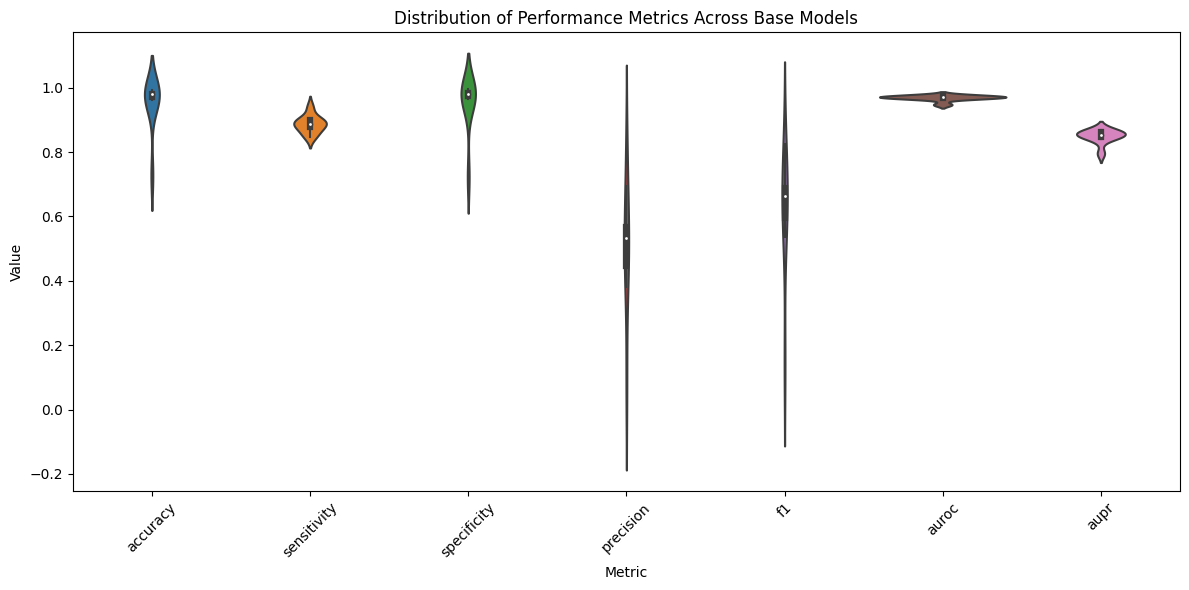


Performance on Test set:
            Model      accuracy   sensitivity   specificity     precision            f1         auroc          aupr
              LR* 0.951 ± 0.079 0.887 ± 0.025 0.952 ± 0.082 0.505 ± 0.193 0.615 ± 0.186 0.968 ± 0.008 0.849 ± 0.021
  Voting ensemble         0.983         0.888         0.986         0.600         0.716         0.974         0.864
Stacking ensemble         0.971         0.898         0.973         0.451         0.601         0.973         0.869


In [6]:

# Main execution
def main():
    # Initialize the analysis
    analysis = CreditFraudAnalysis()
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y = analysis.preprocess_data('/kaggle/input/lr-dataset/creditcard.csv')
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    # Create balanced bagging datasets
    print("Creating balanced bagging datasets...")
    bagging_datasets = analysis.create_balanced_bagging_datasets(X_train, y_train)
    
    # Train base models
    print("Training base models...")
    analysis.train_base_models(bagging_datasets)
    
    # Train meta model
    print("Training meta model...")
    analysis.train_meta_model(X_val, y_val)
    
    # Evaluate models
    print("Evaluating models...")
    results = analysis.evaluate_models(X_test, y_test)
    
    # Plot results
    print("Generating visualizations...")
    analysis.plot_violin_metrics(results)
    analysis.print_comparison_table(results)

if __name__ == "__main__":
    main()